# Additional information: Independent Sample T-Tests and ANOVA in Python

This extra notebook shows how you can do t-test and ANOVA tests in Python (should you not want to use SPSS). The assumption is that you have a continuous dependent variable. Please keep in mind it's absolutely OK to use SPSS for this.

Here we will be using a dataset from Challenge 5.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Data cleaning

In [2]:
df = pd.read_pickle('googlestore_DA5weeklychallenges.pkl')

In [3]:
df['totals_timeOnSite'].isna().value_counts()

True     31047
False    21261
Name: totals_timeOnSite, dtype: int64

In [4]:
df_nona = df.dropna(subset=['totals_timeOnSite'])
len(df_nona)

21261

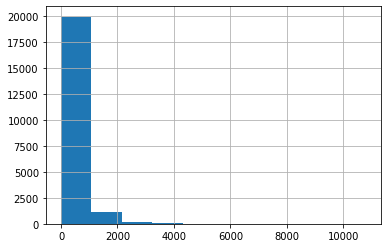

In [5]:
df_nona['totals_timeOnSite'].hist()

<ipython-input-6-252e4a41d1ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nona['log_totals_timeOnSite'] = np.log10(df_nona['totals_timeOnSite'] + 1)


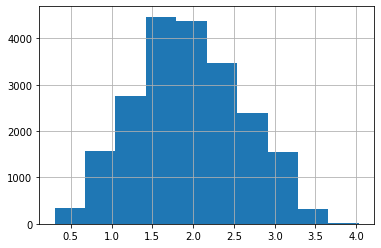

In [6]:
df_nona['log_totals_timeOnSite'] = np.log10(df_nona['totals_timeOnSite'] + 1)
df_nona['log_totals_timeOnSite'].hist()

## 2. T-Tests

Here we'll use a different module from Python, called `scipy`.

In [7]:
from scipy.stats import ttest_ind

Let's say I want to check whether people using Google (0 = Other referrals, 1 = Google as referral) spent more or less in the website. I'm considering that missing values for spent are actually 0 Euros spent.

In [8]:
df_nona['device_isMobile'].value_counts()

False    14147
True      7114
Name: device_isMobile, dtype: int64

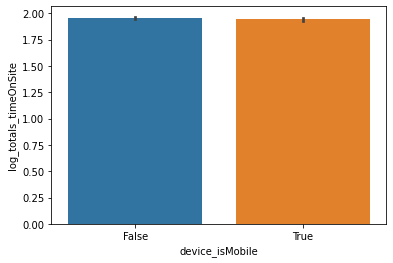

In [9]:
sns.barplot(x='device_isMobile', y='log_totals_timeOnSite', data=df_nona)

In [10]:
mobile_time = df_nona[df_nona['device_isMobile'] == True]['log_totals_timeOnSite']
nonmobile_time = df_nona[df_nona['device_isMobile'] == False]['log_totals_timeOnSite']

The first step I have to do is to split my data in two. One for people using Google, and another for people not using Google. From these data, I only get the actual dependent variable of interest (in my case, spent). The steps below do this.

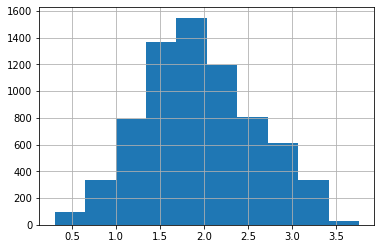

In [12]:
mobile_time.hist()

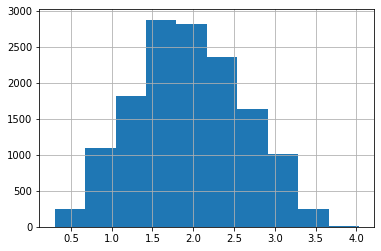

In [13]:
nonmobile_time.hist()

The dataframes above look OK, especially as I know from the descriptives that Google is about 20% of the cases. 

In [14]:
print(len(mobile_time), len(nonmobile_time), len(mobile_time) / (len(mobile_time) + len(nonmobile_time)))

7114 14147 0.33460326419265324


Please note that some assumptions may be violated here given the unequal sample sizes in groups, and I am not checking assumptions here. As this is just an example, I'm ignoring this. But this may be something to consider for your specific analysis (and your limitations).

In the code below, I am comparing the values of each dataframe I created. 

In [15]:
results = ttest_ind(mobile_time.values, nonmobile_time.values)

The results now contain the output of the T-Test, including the p-value:

In [16]:
results

Ttest_indResult(statistic=-1.2300606533630551, pvalue=0.21868800424610377)

## 3. ANOVA


Here we'll use a different module from Python, called `statsmodels`.

In [17]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

Let's find out how different channels may lead to different time spent on the website.

In [18]:
df_nona['channelGrouping'].value_counts()

Organic Search    11173
Referral           3519
Direct             2948
Social             1305
Display            1136
Paid Search         859
Affiliates          321
Name: channelGrouping, dtype: int64

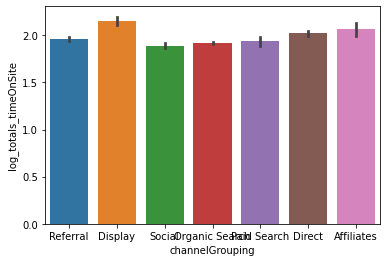

In [19]:
sns.barplot(x='channelGrouping', y='log_totals_timeOnSite', data=df_nona)

We will now the conduct an ANOVA test using `statsmodels`. Note that the equation is very similar to what we would use in R. When using categorical variable, make sure to use `C(...)` to indicate in the equation.

In [20]:
anova_res = ols('log_totals_timeOnSite ~ C(channelGrouping)', data=df_nona).fit()

In [21]:
table = sm.stats.anova_lm(anova_res, typ=2)
print(table)

                         sum_sq       df          F        PR(>F)
C(channelGrouping)    83.643100      6.0  32.490388  3.464077e-39
Residual            9119.365897  21254.0        NaN           NaN


We now find that overall there is a significant effect (the p value `PR(>F)` is much smaller than .01). We can then further use post-hoc pairwise comparisons to find out whether one category is different from the other.

In [22]:
pair_t = anova_res.t_test_pairwise('C(channelGrouping)')
pair_t.result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
Direct-Affiliates,-0.044167,0.038499,-1.147224,2.513020e-01,-0.119629,0.031294,5.682568e-01,False
Display-Affiliates,0.089406,0.041405,2.159311,3.083721e-02,0.008249,0.170562,1.713324e-01,False
Organic Search-Affiliates,-0.147051,0.037082,-3.965596,7.345260e-05,-0.219734,-0.074368,9.544631e-04,True
Paid Search-Affiliates,-0.128292,0.042850,-2.993961,2.756983e-03,-0.212282,-0.044302,2.184421e-02,True
Referral-Affiliates,-0.099261,0.038191,-2.599035,9.355089e-03,-0.174119,-0.024403,6.367614e-02,False
Social-Affiliates,-0.176699,0.040810,-4.329822,1.499128e-05,-0.256689,-0.096709,2.098575e-04,True
Display-Direct,0.133573,0.022875,5.839382,5.315746e-09,0.088737,0.178409,7.973619e-08,True
Organic Search-Direct,-0.102884,0.013563,-7.585796,3.440130e-14,-0.129468,-0.076300,6.195044e-13,True
Paid Search-Direct,-0.084125,0.025398,-3.312308,9.268387e-04,-0.133906,-0.034343,8.310690e-03,True
Referral-Direct,-0.055093,0.016355,-3.368678,7.566379e-04,-0.087150,-0.023037,7.540668e-03,True


By check the last column `reject-hs`, we can see that, e.g., while `display` is not significantly different from `affliates` (2nd row), `organic search` is from `affliates` (3rd row).